Обучите простую модель предсказания цены акций. Используйте рассмотренные на лекции алгоритмы предсказания рядов (не менее двух,например, модель Хольта-Уинтерса и SARIMA). Можно использовать и более сложные алгоритмы предсказания рядов


1. Найдите данные о цене любого биржевого актива

    Данные должны содержать значение цены актива как минимум за каждый день и длительностю как минимум за год. 

    Найти данные можно на kaggle или использовать FAANG датасет из 1-й лабораторной


2. Предобработайте данные

    Временной ряд сложно предсказывать по дням. Сделайте ряд по неделям или месяцам
   
    Удалите из ряда тренд, если он есть. Используйте другие рассмотренные на лекции приёмы


3. Обучите модель
    
    Обучите модели на 80% временного ряда
    
    Предскажите оставшиеся 20% (как минимум 3 точки) ряда с помощью моделей 
    
    Отобразите на графике предсказание моделей и истинные данные


4. Посчитайте метрику

    Метрика должна отражать разницу между предсказанными и истинными данными. Можно выбрать меру MAPE, можно предложить свою

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## 1. Data

In [2]:
df = pd.read_csv("findata.csv")
df.head(5)

,Date,Open,High,Low,Close,Adj Close,Volume
0,2016-03-28,584.400024,584.750000,575.559998,579.869995,579.869995,3121500
1,2016-03-29,580.150024,595.849976,576.500000,593.859985,593.859985,4392600
2,2016-03-30,596.710022,603.239990,595.000000,598.690002,598.690002,3890500
3,2016-03-31,599.280029,600.750000,592.210022,593.640015,593.640015,2681800
4,2016-04-01,590.489990,599.030029,588.299988,598.500000,598.500000,2917400


## 2. Preporcessing

In [3]:
closed = df[['Date', 'Close']]
closed.set_index('Date', inplace = True)
display(closed.head(5), closed.tail(5), )

,Close
Date,
2016-03-28,579.869995
2016-03-29,593.859985
2016-03-30,598.690002
2016-03-31,593.640015
2016-04-01,598.500000


,Close
Date,
2021-03-22,3110.870117
2021-03-23,3137.500000
2021-03-24,3087.070068
2021-03-25,3046.260010
2021-03-26,3052.030029


In [4]:
weeks = closed.index[0:-1:5]
week_data = closed.groupby([i//5 for i in range(0,closed.size)])
mean_week_values = week_data.mean()
close = mean_week_values.assign(Week = weeks)
close.set_index('Week', inplace = True)
close.index = pd.to_datetime(close.index)
display(close.info())
close.head(5)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 252 entries, 2016-03-28 to 2021-03-22
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   252 non-null    float64
dtypes: float64(1)
memory usage: 3.9 KB


None

,Close
Week,
2016-03-28,592.912000
2016-04-04,593.488000
2016-04-11,612.112000
2016-04-18,629.547998
2016-04-25,622.248010


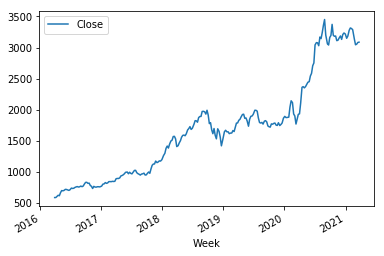

In [5]:
close.plot()

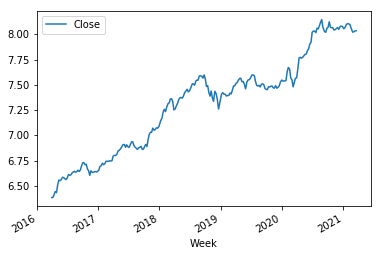

In [6]:
np.log(close).plot()
#Сжалась дисперсия

Text(0.5,0.98,'Распределение разностей (дифференциирование)')

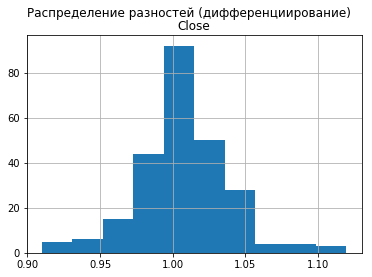

In [7]:
(close/close.shift(1)).hist()
plt.suptitle("Распределение разностей (дифференциирование)")

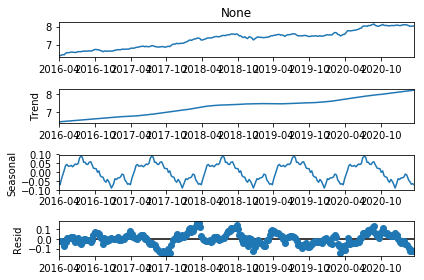

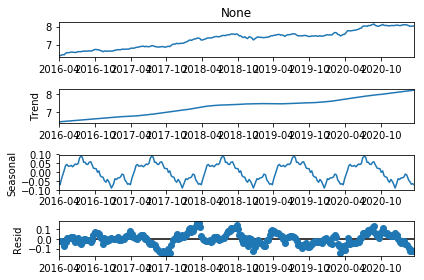

In [8]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(np.log(close), model='additive', period = 50, extrapolate_trend='freq')
result.plot()

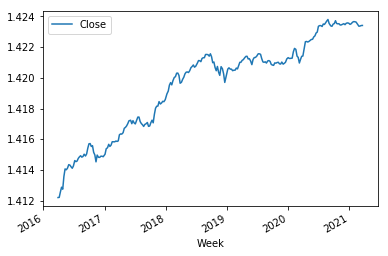

In [9]:
from scipy.special import boxcox, inv_boxcox
boxcox(close, -0.7).plot()

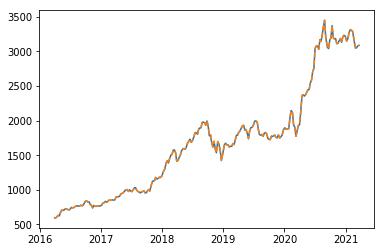

In [10]:
plt.plot(inv_boxcox(boxcox(close, -0.7), -0.7))
plt.plot(close, linestyle = "--")

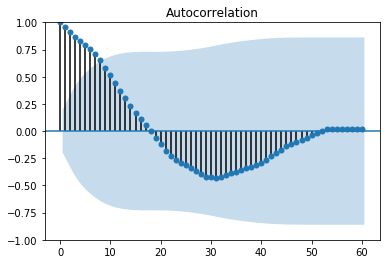

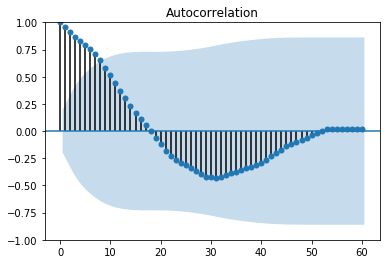

In [11]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(close.asfreq('1d').fillna(method = 'ffill')['Close'][-100:], lags=60)

In [12]:
from statsmodels.tsa.stattools import adfuller
print(adfuller(close.Close))
print(adfuller(np.log(close.Close)))
print(adfuller(boxcox(close, -0.7).Close))
print(adfuller(np.diff(boxcox(close, -0.7).Close)))

(-0.1501895464876846, 0.9442042795733455, 6, 245, {'1%': -3.4573260719088132, '5%': -2.873410402808354, '10%': -2.573095980841316}, 2603.900491677017)
(-1.1593488533731982, 0.690833946569542, 2, 249, {'1%': -3.4568881317725864, '5%': -2.8732185133016057, '10%': -2.5729936189738876}, -957.4799653235114)
(-2.4731642258000863, 0.12214102708572605, 1, 250, {'1%': -3.456780859712, '5%': -2.8731715065600003, '10%': -2.572968544}, -3378.88496527908)
(-13.618544143523959, 1.81526301216063e-25, 0, 250, {'1%': -3.456780859712, '5%': -2.8731715065600003, '10%': -2.572968544}, -3363.6807866246995)


In [13]:
final = np.diff(boxcox(close, -0.7).Close)

## 3. Learning

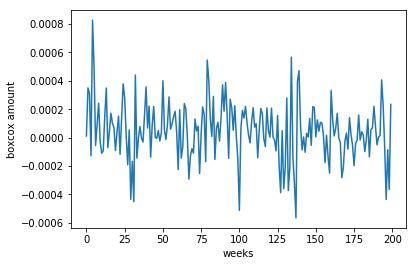

In [14]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(final, test_size=0.2, shuffle = False)
plt.plot(train)
plt.xlabel("weeks")
plt.ylabel("boxcox amount")
plt.show()

### Holt-Winters

In [15]:
def holt_winters(data, alpha, beta, gamma, L, m):
    # находим изначальные сезонности
    periods_cnt = int(len(data)/L)
    s = {} # сами сезонности
    season_avgs = [] # их среднее
    # находим сезонное среднее
    season_avgs = [data[L*i: L*i+L].mean() for i in range(periods_cnt)]
    # находим начальные значения cезонности
    for i in range(L):
        avg_over_summ = 0.0
        for j in range(periods_cnt):
            avg_over_summ += data[L*j+i] - season_avgs[j]
        s[i] = avg_over_summ / periods_cnt
    result = []
    season = []
    l = []
    b = []
    for i in range(len(data) + m):
        if i==0:
            trend_val = sum([(float(data[i+L] - data[i]) / L) for i in range(L)]) / L
            result.append(data[0])
            l.append(data[0])
            b.append(trend_val)
            season.append(s[i%L])
            continue
        if i >= len(data):
            curr_m = i - len(data) + 1
            result.append((l[-1] + curr_m*trend_val) + s[i%L])
        else:
            l.append(alpha*(data[i] - s[i%L]) + (1 - alpha)*(l[-1] + b[-1]))
            b.append(beta * (l[-1] - l[-2]) + b[-1]*(1 - beta))
            s[i%L] = gamma * (data[i] - season[-1]) + (1 - gamma)*s[i%L]
            result.append(l[-1] + b[-1] + s[i%L])
            season.append(s[i%L])
    return np.array(result)

In [16]:
from sklearn.model_selection import TimeSeriesSplit
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error

def learning(data):
    def inner_learning(w):
        errors = []
        alpha, beta, gamma = w
        tscv = TimeSeriesSplit(n_splits=3) 

        for train, test in tscv.split(data):
            preds = holt_winters(data=data[train], L = 1, alpha=alpha, beta=beta, gamma=gamma, m=len(test))
            error = mean_squared_error(preds[-len(test):], data[test])
            errors.append(error)
        return np.mean(np.array(errors))
    return inner_learning

In [17]:
optimizer = minimize(learning(close.Close), x0=[0, 0, 0], method="L-BFGS-B", bounds = ((0, 1), (0, 1), (0, 1)))
optimizer.x

array([1.        , 0.10117904, 0.59492091])

In [18]:
import time
def find_params(data):
    for optimizer in ['L-BFGS-B', 'TNC', 'SLSQP', 'Powell', 'trust-constr']:
        try:
            start = time.time()
            print('\nОптимизатор:', optimizer, end=' ')
            optimizer = minimize(learning(data), x0=[0, 0, 0], method=optimizer, bounds = ((0, 1), (0, 1), (0, 1)))
            alpha, beta, gamma = optimizer.x
            print('\nalpha, beta, gamma:', alpha, beta, gamma)

            end = time.time()
            print('Скорость сходимости (сек)', round(end - start, 2))
        except:
            # часть из них почему-то выдает ошибки из-за ошибок кодирования
            pass

In [19]:
def get_params(data):
    optimizer = minimize(learning(data), x0=[0, 0, 0], method='L-BFGS-B', bounds = ((0, 1), (0, 1), (0, 1)))
    return optimizer.x
def predict(data, percent):
    alpha, beta, gamma = get_params(data)
    train, test = train_test_split(data, test_size=percent, shuffle = False)
    return train, test, holt_winters(data=train, L = 30, alpha=alpha, beta=beta, gamma=gamma, m = test.size)

In [20]:
data = close.reset_index(drop=True).Close
#print(data)
find_params(data)


Оптимизатор: L-BFGS-B 
alpha, beta, gamma: 1.0 0.101179038930667 0.5949209085363626
Скорость сходимости (сек) 4.92

Оптимизатор: TNC 
alpha, beta, gamma: 0.0020027945102719102 0.41826904467689685 0.0026692943861453267
Скорость сходимости (сек) 28.81

Оптимизатор: SLSQP 
alpha, beta, gamma: 0.0 0.0 0.0
Скорость сходимости (сек) 0.35

Оптимизатор: Powell 
alpha, beta, gamma: 0.9776776295735594 0.9999338930386481 0.6043609338390263
Скорость сходимости (сек) 7.74

Оптимизатор: trust-constr 

C:\Users\agata\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_hessian_update_strategy.py:186: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
C:\Users\agata\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_hessian_update_strategy.py:186: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
C:\Users\agata\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\_hessian_update_strategy.py:186: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of u


alpha, beta, gamma: 0.9999999999763987 0.5739807818696303 0.5949208323734282
Скорость сходимости (сек) 18.31


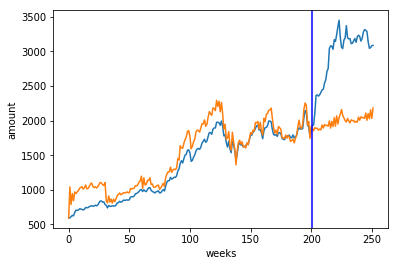

In [21]:
data_exp = close.reset_index(drop=True)
#display(data)
train, test, pred = predict(data, 0.2)
plt.plot(data)
plt.plot(pred)
plt.axvline(x = train.size, color = 'b')
plt.xlabel("weeks")
plt.ylabel("amount")
plt.show()

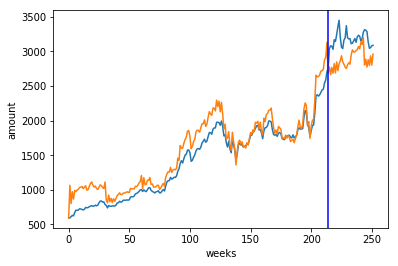

In [22]:
data_exp = close.reset_index(drop=True)
#display(data)
train, test, pred = predict(data, 0.15)
plt.plot(data)
plt.plot(pred)
plt.axvline(x = train.size, color = 'b')
plt.xlabel("weeks")
plt.ylabel("amount")
plt.show()

### Sarima

In [23]:
!pip install pmdarima

Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.


In [24]:
from pmdarima.arima import auto_arima

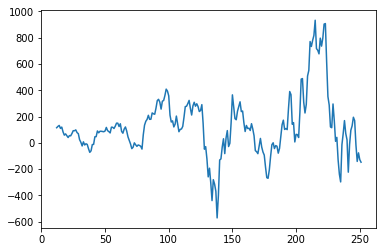

In [25]:
data[:].diff(12).plot()

In [26]:
box = -1
def fit(data, percent):
    train, test = train_test_split(data, test_size=percent, shuffle = False)
    model = auto_arima(boxcox(train, box), start_p=1, start_q=1,
                           max_p=5, max_q=5,
                           start_P=0, m = 26,
                           d=1, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)
    model.summary()
    return train, test, model
def predict(model, test):
    fitted, confint = model.predict(n_periods=test.size, return_conf_int=True)
    return fitted

In [27]:
train, test, model = fit(data, 0.20)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[26]             : AIC=-3131.602, Time=1.58 sec
 ARIMA(0,1,0)(0,1,0)[26]             : AIC=-3091.453, Time=0.15 sec
 ARIMA(1,1,0)(1,1,0)[26]             : AIC=-3117.262, Time=1.15 sec
 ARIMA(0,1,1)(0,1,1)[26]             : AIC=-3134.000, Time=1.54 sec
 ARIMA(0,1,1)(0,1,0)[26]             : AIC=-3096.463, Time=0.64 sec
 ARIMA(0,1,1)(1,1,1)[26]             : AIC=-3128.539, Time=1.48 sec
 ARIMA(0,1,1)(0,1,2)[26]             : AIC=-3094.079, Time=3.89 sec
 ARIMA(0,1,1)(1,1,0)[26]             : AIC=-3109.748, Time=0.70 sec
 ARIMA(0,1,1)(1,1,2)[26]             : AIC=-3086.297, Time=6.25 sec
 ARIMA(0,1,0)(0,1,1)[26]             : AIC=-3119.804, Time=0.73 sec
 ARIMA(0,1,2)(0,1,1)[26]             : AIC=-3127.762, Time=1.48 sec
 ARIMA(1,1,0)(0,1,1)[26]             : AIC=-3133.930, Time=0.92 sec
 ARIMA(1,1,2)(0,1,1)[26]             : AIC=-3118.630, Time=2.74 sec
 ARIMA(0,1,1)(0,1,1)[26] intercept   : AIC=-3142.434, Time=5.43 sec
 ARIM

In [28]:
fitted = predict(model, test)
fitted.head(5)

201    0.999461
202    0.999449
203    0.999436
204    0.999430
205    0.999421
dtype: float64

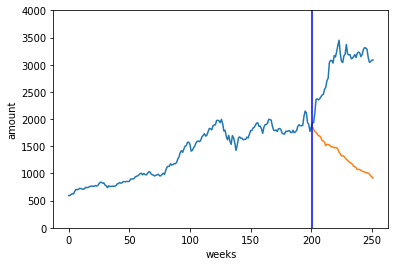

In [29]:
plt.plot(data)
plt.plot(inv_boxcox(fitted, box))
plt.axvline(x = train.size, color = 'b')
plt.ylim((0, 4000))
plt.xlabel("weeks")
plt.ylabel("amount")
plt.show()

In [30]:
train2, test2, model2 = fit(data, 0.15)
fitted2 = predict(model2, test2)
fitted2.head(5)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[26]             : AIC=-3368.849, Time=2.20 sec
 ARIMA(0,1,0)(0,1,0)[26]             : AIC=-3333.251, Time=0.24 sec
 ARIMA(1,1,0)(1,1,0)[26]             : AIC=-3349.766, Time=0.75 sec
 ARIMA(0,1,1)(0,1,1)[26]             : AIC=-3361.755, Time=1.52 sec
 ARIMA(1,1,1)(0,1,0)[26]             : AIC=-3334.294, Time=0.27 sec
 ARIMA(1,1,1)(1,1,1)[26]             : AIC=-3364.613, Time=1.60 sec


C:\Users\agata\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\statespace\sarimax.py:1906: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(1,1,1)(0,1,2)[26]             : AIC=-3330.294, Time=3.62 sec
 ARIMA(1,1,1)(1,1,0)[26]             : AIC=-3362.855, Time=1.73 sec
 ARIMA(1,1,1)(1,1,2)[26]             : AIC=-3345.627, Time=7.40 sec
 ARIMA(1,1,0)(0,1,1)[26]             : AIC=-3377.437, Time=0.89 sec
 ARIMA(1,1,0)(0,1,0)[26]             : AIC=-3337.541, Time=0.22 sec
 ARIMA(1,1,0)(1,1,1)[26]             : AIC=-3364.997, Time=1.07 sec
 ARIMA(1,1,0)(0,1,2)[26]             : AIC=-3333.541, Time=4.29 sec
 ARIMA(1,1,0)(1,1,2)[26]             : AIC=-3337.003, Time=2.90 sec
 ARIMA(0,1,0)(0,1,1)[26]             : AIC=-3373.540, Time=1.76 sec
 ARIMA(2,1,0)(0,1,1)[26]             : AIC=-3357.614, Time=1.07 sec
 ARIMA(2,1,1)(0,1,1)[26]             : AIC=-3347.899, Time=3.08 sec
 ARIMA(1,1,0)(0,1,1)[26] intercept   : AIC=-3380.077, Time=4.39 sec
 ARIMA(1,1,0)(0,1,0)[26] intercept   : AIC=-3340.727, Time=0.77 sec
 ARIMA(1,1,0)(1,1,1)[26] intercept   : AIC=-3369.364, Time=9.45 sec
 ARIMA(1,1,0)(0,1,2)[26] intercept   : AIC=-3336

C:\Users\agata\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\statespace\sarimax.py:1906: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(0,1,1)(0,1,2)[26] intercept   : AIC=-3335.101, Time=7.52 sec
 ARIMA(0,1,1)(1,1,0)[26] intercept   : AIC=-3360.694, Time=3.33 sec
 ARIMA(0,1,1)(1,1,2)[26] intercept   : AIC=-3346.930, Time=16.26 sec
 ARIMA(0,1,2)(0,1,1)[26] intercept   : AIC=-3378.601, Time=2.70 sec
 ARIMA(1,1,2)(0,1,1)[26] intercept   : AIC=-3377.955, Time=10.92 sec

Best model:  ARIMA(0,1,1)(0,1,1)[26] intercept
Total fit time: 165.073 seconds


214    0.999632
215    0.999634
216    0.999627
217    0.999627
218    0.999629
dtype: float64

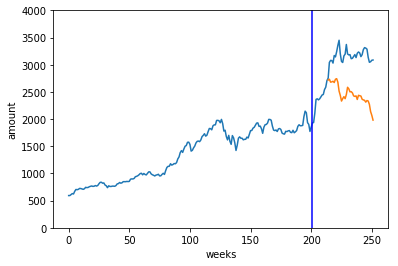

In [31]:
plt.plot(data)
plt.plot(inv_boxcox(fitted2, box))
plt.axvline(x = train2.size, color = 'b')
plt.ylim((0, 4000))
plt.xlabel("weeks")
plt.ylabel("amount")
plt.show()

## 4. Метрика

In [32]:
test1 = data_exp
train, test2 =  train_test_split(data_exp, test_size=0.15, shuffle = False)
test2.head()

,Close
214,2753.070020
215,3042.240039
216,3079.354004
217,3076.712012
218,3029.971973


In [33]:
pred1 = pred
pred2 = inv_boxcox(fitted2, box)
pred2.head()

214    2718.157683
215    2733.036670
216    2679.204840
217    2684.341493
218    2696.046386
dtype: float64

In [34]:
from sklearn.metrics import mean_absolute_percentage_error

In [35]:
mean_absolute_percentage_error(test1, pred1)

0.12444457068264482

In [36]:
mean_absolute_percentage_error(test2, pred2)

0.22264835274788264